# Learning `Deep Convolutional GAN`

In [1]:
import os
import sys

import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Plot a random image

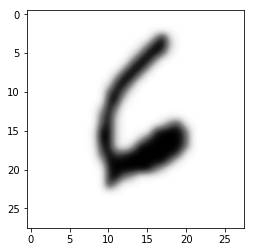

In [3]:
sample_image = data.train.images[3]
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys', interpolation='bicubic')

## Hyperparams

In [4]:
# Inputs
img_size = 28
img_channel = 1

# Network
conv_filter = 5
deconv_filter = 3
strides = [1, 2, 2, 1]
conv_1 = 16
conv_2 = 32
fc_1_size = 1024
fc_2_size = 1

# Training
learning_rate = 1e-3
batch_size = 32

## Building the Network

### Helper functions

In [5]:
# Weight initializer
def weight(shape, layer_name):
    return tf.get_variable(layer_name, shape, initializer=tf.truncated_normal_initializer(stddev=0.2))

# Bias initializer
def bias(shape, layer_name):
    return tf.get_variable(layer_name, [shape], initializer=tf.constant_initializer(0))

# Convolutional block
def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer

# Deconvolutional block
def deconv_block(layer, W, b, activation_fn=tf.nn.relu, batch_norm=None):
    layer = tf.nn.conv2d(layer, W, strides=[1, 2, 2, 1], padding='SAME')
    layer = layer + b
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, epsilon=1e-5, scope=batch_norm)
    layer = activation_fn(layer)
    return layer

# Fully connected layer
def fully_connected(layer, W, b, use_relu=True):
    layer = tf.matmul(layer, W) + b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

# Flatten layer
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=np.int32).prod()
    flattened = tf.reshape(layer, [-1, features])
    return flattened, features

### Discriminator `(Deep Convolutional neural net)`

In [6]:
def discriminator(image, reuse=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
        # 1st convolutional block
        d_conv_W1 = weight(shape=[conv_filter, conv_filter, img_channel, conv_1], layer_name='d_conv_W1')
        d_conv_b1 = bias(shape=conv_1, layer_name='d_conv_b1')
        d_conv_1 = conv_block(image, d_conv_W1, d_conv_b1)
        # 2nd convolutional block
        d_conv_W2 = weight(shape=[conv_filter, conv_filter, conv_1, conv_2], layer_name='d_conv_W2')
        d_conv_b2 = bias(shape=conv_2, layer_name='d_conv_b2')
        d_conv_2 = conv_block(d_conv_1, d_conv_W2, d_conv_b2)
        # Flatten layer
        flattened, features = flatten(d_conv_2)
        # 1st Fully connected layer
        d_fc_W1 = weight(shape=[features, fc_1_size], layer_name='d_fc_W1')
        d_fc_b1 = bias(shape=fc_1_size, layer_name='d_fc_b1')
        fc_1 = fully_connected(flattened, d_fc_W1, d_fc_b1, use_relu=True)
        # 2nd Fully connected layer
        d_fc_W2 = weight(shape=[fc_1_size, fc_2_size], layer_name='d_fc_W2')
        d_fc_b2 = bias(shape=fc_2_size, layer_name='d_fc_b2')
        fc_2 = fully_connected(fc_1, d_fc_W2, d_fc_b2, use_relu=False)
        return fc_2

### Generator `(Deep Deconvolutional neural net)`

In [7]:
def generator(z, batch_size, z_dim, scale=56):
    up_scale = scale * scale
    # 1st Deconvolutional block
    g_deconv_W1 = weight(shape=[z_dim, up_scale], layer_name='g_deconv_W1')
    g_deconv_b1 = bias(shape=up_scale, layer_name='g_deconv_b1')
    g_deconv_1 = tf.matmul(z, g_deconv_W1) + g_deconv_b1
    g_deconv_1 = tf.reshape(g_deconv_1, [-1, scale, scale, img_channel])
    g_deconv_1 = tf.contrib.layers.batch_norm(g_deconv_1, epsilon=1e-5, scope='bn_G1')
    g_deconv_1 = tf.nn.relu(g_deconv_1)
    # 2nd Deconvolutional block
    g_deconv_W2 = weight(shape=[deconv_filter, deconv_filter, img_channel, z_dim//2], layer_name='g_deconv_W2')
    g_deconv_b2 = bias(shape=z_dim//2, layer_name='g_deconv_b2')
    g_deconv_2 = deconv_block(g_deconv_1, g_deconv_W2, g_deconv_b2, batch_norm='bn_G2')
    g_deconv_2 = tf.image.resize_images(g_deconv_2, [scale, scale])
    # 3rd Deconvolutional block
    g_deconv_W3 = weight(shape=[deconv_filter, deconv_filter, z_dim//2, z_dim//4], layer_name='g_deconv_W3')
    g_deconv_b3 = bias(shape=z_dim//4, layer_name='g_deconv_b3')
    g_deconv_3 = deconv_block(g_deconv_2, g_deconv_W3, g_deconv_b3, batch_norm='bn_G3')
    g_deconv_3 = tf.image.resize_images(g_deconv_3, [scale, scale])
    # Final Deconvolutional block
    g_deconv_W4 = weight(shape=[1, 1, z_dim//4, 1], layer_name='g_deconv_W4')
    g_deconv_b4 = bias(shape=1, layer_name='g_deconv_b4')
    g_deconv_4 = deconv_block(g_deconv_3, g_deconv_W4, g_deconv_b4, activation_fn=tf.nn.sigmoid)
    
    return g_deconv_4

In [8]:
z_dim = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dim])

In [9]:
gen_img = generator(z_placeholder, 1, z_dim)
z_batch = np.random.normal(0, 1, [1, z_dim])

(1, 28, 28, 1)


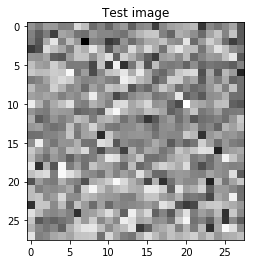

In [10]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_img = sess.run(gen_img, feed_dict={z_placeholder: z_batch})
    print(test_img.shape)
    plt.title('Test image')
    plt.imshow(test_img.reshape([img_size, img_size]), cmap='Greys')

In [11]:
tf.reset_default_graph()

z_placeholder = tf.placeholder(tf.float32, [None, z_dim], name='z_placeholder')
x_placeholder = tf.placeholder(tf.float32, [None, img_size, img_size, img_channel], name='x_placeholder')

# Genenrated img
Gz = generator(z_placeholder, batch_size, z_dim)
# Prob. for real img
Dx = discriminator(x_placeholder)
# Prob. for generated img
Dg = discriminator(Gz, reuse=True)

### Loss functions

In [12]:
# Discriminator loss
d_loss_real = tf.nn.softmax_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx))
d_loss_fake = tf.nn.softmax_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg))
# Generator loss
g_loss = tf.nn.softmax_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg))

In [13]:
# Discriminator
d_loss_real = tf.reduce_mean(d_loss_real)
d_loss_fake = tf.reduce_mean(d_loss_fake)
# Generator
g_loss = tf.reduce_mean(g_loss)

### Retrieve Trainable Vars

In [14]:
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

print([var.name for var in d_vars])
print([var.name for var in g_vars])

['d_conv_W1:0', 'd_conv_b1:0', 'd_conv_W2:0', 'd_conv_b2:0', 'd_fc_W1:0', 'd_fc_b1:0', 'd_fc_W2:0', 'd_fc_b2:0']
['g_deconv_W1:0', 'g_deconv_b1:0', 'g_deconv_W2:0', 'g_deconv_b2:0', 'g_deconv_W3:0', 'g_deconv_b3:0', 'g_deconv_W4:0', 'g_deconv_b4:0']


### Optimization

In [15]:
# Discriminator optimization
d_opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_real, var_list=d_vars)
d_opt_fake = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_fake, var_list=d_vars)
# Generator optimization
g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

## Tensorboard stuff